# Install Libraries

In [1]:
!pip install pillow
!nvidia-smi

Wed May  4 16:13:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Mount Google Drive

In [2]:
from google.colab import drive
drive_dir = "/drive"
drive.mount(drive_dir, force_remount=True)

Mounted at /drive


# Download Dataset

In [3]:
DATASET_FILE = "scalene_triangle_0_355_step5_randomdisp_5000randomtest_c0.9-1.0_b0.75-1.0.zip"
DATASET_DIR = "scalene_triangle_0_355_step5_randomdisp_5000randomtest_c0.9-1.0_b0.75-1.0"
!rm -rf "$DATASET_DIR"
!curl -L https://github.com/joshbarrass/Y4ProjectNotebooks/raw/master/$DATASET_FILE > "$DATASET_FILE"
!unzip -d "$DATASET_DIR" "$DATASET_FILE" > /dev/null

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 23.2M  100 23.2M    0     0  21.3M      0  0:00:01  0:00:01 --:--:-- 21.3M


# Define Helper Functions

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.spatial.transform import Rotation as R

D6_SHAPE = (3, 2)

def normalise(x):
    return x / np.linalg.norm(x)

def from_SO3_to_6D(SO3):
    """Convert an SO(3) rotation matrix to a 6D internal representation."""
    return SO3[:,:2]

def from_6D_to_SO3(D6):
    """Convert a 6D internal representation to an SO(3) rotation matrix."""
    b1 = normalise(D6[:,0])
    b2 = normalise(D6[:,1] - np.dot(b1, D6[:,1])*b1)
    b3 = np.cross(b1, b2)
    return np.array([b1, b2, b3]).T

def tf_6D_to_SO3(D6):
  """tensorflow-compatible conversion from 6D to SO(3). Used in the D6Convert layer."""
  a1 = D6[:,:,0]
  a2 = D6[:,:,1]
  b1 = tf.math.l2_normalize(a1, axis=-1)
  b2 = tf.math.l2_normalize(a2 - tf.reduce_sum(b1*a2)*b1, axis=-1)
  b3 = tf.linalg.cross(b1, b2)
  return tf.stack([b1, b2, b3], axis=2)

class D6Convert(layers.Layer):
  def call(self, inputs):
    target_input_shape = tf.TensorShape(((None,) + D6_SHAPE))
    if not inputs.shape.is_compatible_with(target_input_shape):
      raise TypeError("inputs to D6Convert should have shape {}, not {}".format(target_input_shape, inputs.shape))
    return tf_6D_to_SO3(inputs)

### DEPRECATED: Returns wrong value
# def SO3_distance(M1, M2):
#  """Returns the distance between two SO3 matrices in degrees"""
#  R = M1 * np.linalg.inv(M2)
#  return np.rad2deg(np.arccos((np.trace(R)-1)/2))

# Implement Quaternion SO(3) Distance

In [5]:
# quaternion [x, y, z, w]: w + xi + yj + zk
# this is the format outputted by scipy
def SO3_distance(M1, M2):
  """Returns the angle between two SO3 matrices in degrees.

  This is done by converting the matrices to quaternions and multiplying the
  conjugate of one with the other. The scalar part of the resulting quaternion
  is then cos(theta/2). The expression has been simplified to calculate only the
  scalar part."""
  x1, y1, z1, w1 = R.from_matrix(M1).as_quat()
  x2, y2, z2, w2 = R.from_matrix(M2).as_quat()
  angle = np.rad2deg(2*np.arccos(w1*w2 + x1*x2 + y1*y2 + z1*z2))
  # maximum rotation away from a given angle is 180 degrees
  # any further and you reduce the angle by rotating the opposite direction
  # some edge cases produce angles > 180 degrees, so rectify these
  if angle > 180:
    return 360 - angle
  return angle

### TEST SO3_distance
for i in range(100):
  test_angle1, test_angle2 = np.random.uniform(0, 180, 2) # max difference should be 180, as > 180 is no longer the shortest angle
  testM1 = R.from_euler("zyx", [test_angle1, 0, 0], degrees=True).as_matrix()
  testM2 = R.from_euler("zyx", [test_angle2, 0, 0], degrees=True).as_matrix()
  test_true_angle = abs(test_angle1-test_angle2)
  test_angle = abs(SO3_distance(testM1, testM2))
  np.testing.assert_approx_equal(test_angle, test_true_angle, 5)

In [6]:
SO31 = R.from_euler("zyx",[3, 2, 1]).as_matrix()
D61 = from_SO3_to_6D(SO31)
SO32 = R.from_euler("zyx",[0.5, 1, 1.2]).as_matrix()
D62 = from_SO3_to_6D(SO32)
print("True:", SO31, "\n", SO32, sep="")
print("np1:", from_6D_to_SO3(D61))
print("np2:", from_6D_to_SO3(D62))
print("tf:", tf_6D_to_SO3(np.array([D61, D62])))

True:[[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
[[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
np1: [[ 0.41198225  0.05872664  0.90929743]
 [-0.68124272 -0.64287284  0.35017549]
 [ 0.60512725 -0.76371834 -0.2248451 ]]
np2: [[ 0.47415988 -0.25903472  0.84147098]
 [ 0.86199739 -0.05800686 -0.50358287]
 [ 0.17925654  0.96412459  0.19578273]]
tf: tf.Tensor(
[[[ 0.41198225  0.05872664  0.90929743]
  [-0.68124272 -0.64287284  0.35017549]
  [ 0.60512725 -0.76371834 -0.2248451 ]]

 [[ 0.47415988 -0.25903472  0.84147098]
  [ 0.86199739 -0.05800686 -0.50358287]
  [ 0.17925654  0.96412459  0.19578273]]], shape=(2, 3, 3), dtype=float64)


# Create Image Centering Function

In [7]:
import numpy as np
from scipy import ndimage
from PIL import Image
def centre_image(a: np.ndarray, target_centre=(0,0), interp=0):
  """Centres a single-channel image using centre of mass.
  
  Target centre is defined such that (x=0,y=0) is the centre of the image.
  Increasing x moves the centre to the right, increasing y moves the centre
  down."""
  if len(a.shape) == 2:
    a = a.reshape((1,) + a.shape)

  # determine all centres of mass
  # TODO: can potentially take advantage of labelling to remove "noise islands"
  if len(a.shape) == 3:
    COM = np.zeros((a.shape[0], 2))
    for i in range(a.shape[0]):
      COM[i] = ndimage.measurements.center_of_mass(a[i])
  else:
    raise TypeError("a should be either 2D image or an array of 2D")

  output = np.zeros(a.shape)

  # translate COM to centre of image
  for i in range(a.shape[0]):
    im = a[i]
    final_target = (im.shape[0]/2 + target_centre[0],
                     im.shape[1]/2 + target_centre[1])
    # use affine transform with a=1, e=1, i=1, c=x, f=y to translate
    translation = (COM[i][0] - final_target[0], COM[i][1] - final_target[1])
    transform = np.array([[1, 0, translation[0]],
                          [0, 1, translation[1]],
                          [0, 0, 1]])
    output[i] = ndimage.affine_transform(im, transform, order=interp, mode="wrap")
  
  return output


# Load and Pre-Process Training Data

In [8]:
import os
import random
from scipy.spatial.transform import Rotation as R
from PIL import ImageFilter
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.preprocessing.image as impreproc
from tensorflow.python.ops import random_ops

def polar_to_cartesian(r, theta):
  r = np.abs(r)
  return r*np.cos(theta), r*np.sin(theta)

# https://stackoverflow.com/a/4602224
# Licensed CC BY-SA 3.0
def combined_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def random_brightness(image, min_delta, max_delta, seed=None):
  """Adjust the brightness of images by a random factor.
  Input image should be normalised, with pixel values in the range [0, 1].
  The output image values will be clipped to the range [0, 1].

  This function is a modification of tensorflow's `tf.image.random_brightness`.
  
  Args:
    image: An image or images to adjust.
    min_delta: float
    max_delta: float, must be greater than min_delta.
    seed: A Python integer. Used to create a random seed. See
      `tf.compat.v1.set_random_seed` for behavior.

  Returns:
    The brightness-adjusted image(s).
  Raises:
    ValueError: if `min_delta` is greater than `max_delta`.
  """
  if min_delta > max_delta:
    raise ValueError('min_delta must be less than max_delta.')

  delta = random_ops.random_uniform([], min_delta, max_delta, seed=seed)
  return tf.clip_by_value(tf.image.adjust_brightness(image, delta), 0, 1)

## onload functions. Applied directly to a PIL Image. Take the Image as their
## only argument, and return a single Image.

def onload_MeanResizeImage(target_size):
  """Returns an onload function to resize the image to the target size using
  mean resizing via PIL."""
  def MeanResizeImage(im):
    return im.resize(target_size, Image.BOX)
  return MeanResizeImage

def onload_MedianResizeImage(target_size):
  """Returns an onload function to resize the image to the target size using
  median resizing. Only works when the old dimensions are exactly divisible by
  the new dimensions."""
  def MedianResizeImage(im):
    a = np.array(im)
    assert len(a.shape) == 2 # assert 2D image
    assert len(target_size) == 2
    old_w, old_h = a.shape
    new_w, new_h = target_size
    # assert dimensions are divisible
    chunk_w, rem = divmod(old_w, new_w)
    assert rem == 0
    chunk_h, rem = divmod(old_h, new_h)
    assert rem == 0

    # construct the target and intermediate shapes
    target_shape = target_size + (chunk_w, chunk_h)
    inter_shape = (target_shape[0], target_shape[2], target_shape[1], target_shape[3])

    # chunk the image
    a = a.reshape(inter_shape).swapaxes(1, 2)
    
    # flatten the final dimension and apply median
    a = a.reshape(target_size + (chunk_w*chunk_h,))
    a = np.median(a, axis=-1).astype(a.dtype)

    return Image.fromarray(a)
  return MedianResizeImage
    
def onload_GaussianBlur(radius):
  """Returns an onload function to blur the image."""
  image_filter = ImageFilter.GaussianBlur(radius=radius)
  def GaussianBlur(im):
    return im.filter(image_filter)
  return GaussianBlur

def onload_SEMNoise(gauss=2, poisson=5):
  """Returns an onload function that approximates SEM noise and adds it to the
  image."""
  def SEMNoise(im):
    # convert the image to an array for ease
    # use float32 for precision and convert back to int at the end
    a = np.array(im, dtype="float")

    # generate a flat array of N(0,1) numbers and reshape to match the image
    rand = np.random.normal(loc=0.0, scale=1.0, size=np.prod(a.shape)).reshape(a.shape)

    # apply the noise as in https://doi.org/10.1016/j.mee.2019.111051
    noised = a + (gauss + poisson*np.sqrt(a))*rand

    # scale the image to the appropriate range
    final = noised - np.min(noised)
    final /= np.max(final)
    final *= 255

    # round to nearest pixel value and convert back to PIL
    a_prime = final.round().astype("uint8")
    return Image.fromarray(a_prime, "L")
  return SEMNoise


## preproc functions. Receive the complete x and y data arrays, and should
## return complete x and y data arrays. Augmentation can be performed at
## this stage.
## These functions are not guaranteed to be pure! If you do not want to modify
## the original array in these functions, make a copy of the array at the start
## of your function.

def preproc_Normalise():
  """Returns a preproc function that will divide all data by 255 to normalise it"""
  def Normalise(xdata, ydata):
    return xdata/255., ydata
  return Normalise

## TODO: fix this -- data is incorrect when this is used
#def preproc_Centre(interpolation_order=0):
#  """Returns a preproc function that will centre all images as best as possible.
#  Can optionally utilise interpolation (should only be used for debugging)"""
#  def Centre(xdata, ydata):
#    return centre_image(xdata.reshape(xdata.shape[:-1]),
#                        interp=interpolation_order).reshape(xdata.shape), ydata
#  return Centre

def preproc_Centre(interpolation_order=0):
  """Returns a preproc function that will centre all images as best as possible.
  Can optionally utilise interpolation (should only be used for debugging)"""
  def Centre(xdata, ydata):
    newxdata = np.zeros(xdata.shape, dtype=xdata.dtype)
    for i in range(xdata.shape[0]):
      im = xdata[i]
      newxdata[i] = centre_image(im.reshape(im.shape[:-1]),
                                 interp=interpolation_order).reshape(im.shape)
    return newxdata, ydata
  return Centre

def preproc_CentreAug(sigma, repeats=1):
  """Augment the centring of the image as a pre-processing step. Image will be
  intentionally miscentred following a Gaussian distribution of the given
  sigma. This is repeated a number of times for each image to increase the size
  of the dataset (by default, the size will be the same)."""
  def CentreAug(xdata, ydata):
    length = xdata.shape[0]
    new_length = length*repeats
    newxdata = np.zeros((new_length,) + xdata.shape[1:], dtype=xdata.dtype)
    newydata = np.zeros((new_length,) + ydata.shape[1:], dtype=ydata.dtype)

    for i in range(length):
      im = xdata[i]
      rot = ydata[i]
      for j in range(repeats):
        r = np.random.normal(loc=0, scale=sigma)
        theta = np.random.uniform(low=0, high=2*np.pi)
        newxdata[i*repeats + j] = centre_image(im.reshape(im.shape[:-1]),
                                               target_centre=polar_to_cartesian(r, theta)).reshape(im.shape)
        newydata[i*repeats + j] = rot
    
    return newxdata, newydata
    
  return CentreAug

def preproc_Shuffle():
  """Returns a preproc function that shuffles the order of the data."""
  def Shuffle(xdata, ydata):
    print("shuffling")
    return combined_shuffle(xdata, ydata)
  return Shuffle

def preproc_DynamicRange(max=255):
  """Returns a preproc function that attempts to maximise the dynamic range of
  all images in the dataset. The "max" argument corresponds to the maximum value
  a pixel can take. In a standard image this should be 255, but if the image has
  already been normalised this should be changed to 1."""
  def DynamicRange(xdata, ydata):
    dtype = xdata.dtype
    # find minimum of each image
    # search over all axes except the one that determines the image itself
    min_data = np.min(xdata, axis=(1,2,3))
    # restore the extra axes for proper application to each pixel
    xdata -= min_data.reshape(min_data.shape + (1,1,1))

    # repeat for maximum
    max_data = np.max(xdata, axis=(1,2,3))
    xdata *= max
    xdata /= max_data.reshape(max_data.shape + (1,1,1))

    # validate data
    assert (np.max(xdata, axis=(1,2,3)) == max).all()
    assert (np.min(xdata, axis=(1,2,3)) == 0).all()

    # ensure dtype is correct
    return xdata.astype(dtype), ydata
  return DynamicRange

def preproc_ContrastAug(min=1, max=1, renormalise=True):
  """Returns a preproc function that augments the contrast of the image using
  the image preprocessing functions provided by keras. The function used by
  keras will scale the pixel values back to [0, 255], even if they have already
  been normalised. By setting renormalise=True, the image will be normalised to
  the range [0, 1] again."""
  def ContrastAug(xdata, ydata):
    for i in range(xdata.shape[0]):
      # even though this says brightness, it is a multiplicative function
      # this is closer to the definition of contrast than brightness
      xdata[i] = impreproc.random_brightness(xdata[i], (min, max))
    if renormalise:
      xdata /= 255.
    return xdata, ydata
  return ContrastAug

def preproc_BrightnessAug(min_delta=0, max_delta=0, seed=None):
  """Returns a preproc function that augments the brightness of the image. A
  random value between min_delta and max_delta is added to each pixel. The input
  image should be normalised to the range [0, 1], and the output image will be
  clipped to this range."""
  def BrightnessAug(xdata, ydata):
    for i in range(xdata.shape[0]):
      xdata[i] = random_brightness(xdata[i], min_delta, max_delta)
    return xdata, ydata
  return BrightnessAug

def preproc_LinearShift(m=1, c=0, min=0, max=1):
  """Returns a preproc function that applies a linear transformation to the
  image data, of the form I' = m*I + c. If the data falls below min it will be
  made equal to min, and if it exceeds max it will be made equal to max."""
  def LinearShift(xdata, ydata):
    xdata = m*xdata + c
    xdata[xdata > max] = max
    xdata[xdata < min] = min
    return xdata, ydata
  return LinearShift

def preproc_LinearAug(m=(1,1), c=(0,0), min=0, max=1):
  """Returns a preproc function that applies a linear transformation to the
  image data like LinearShift, but the parameters of this transform will be
  chosen from a uniform distribution in the specified ranges."""
  def LinearAug(xdata, ydata):
    md = np.random.uniform(m[0], m[1], xdata.shape[0])
    cd = np.random.uniform(c[0], c[1], xdata.shape[0])
    # reshape to properly apply to each image
    md = md.reshape(md.shape + (1,1,1))
    cd = cd.reshape(cd.shape + (1,1,1))

    xdata = md*xdata + cd
    return xdata.clip(min, max), ydata
  return LinearAug

class DataLoader(keras.utils.Sequence):
  """Loads images and applies pre-processing and augmentation."""
  def __init__(self, dataset_dir, batch_size=32, onload=[], preproc=[], aug=[]):
    """Inputs:
     - dataset_dir: directory containing the dataset to be loaded.
     - batch_size: batch size of the model.
     - onload: list of functions to be applied on each PIL Image as it is loaded.
     - preproc: list of functions to be applied on the complete data arrays after
                image loading.
     - aug: list of preproc functions to applied on the complete data arrays at
            the beginning of each epoch.
     """
    self.dataset_dir = dataset_dir # storing for reference
    self.batch_size = batch_size

    self.aug = aug

    # find images
    image_files = sorted(os.listdir(dataset_dir))
    total_images = len(image_files)
    print(f"Dataset contains {total_images} images")
    if total_images == 0:
      raise ValueError("dataset has no images")

    # load the first image to determine the data size
    im0, rot0 = self.load_image(os.path.join(dataset_dir, image_files[0]), onload)
    image_shape = im0.size + (1,)
    rot_shape = rot0.shape
    print(f"Image shape is {image_shape}")

    # construct the initial data arrays to hold each image file
    self.xdata = np.zeros((total_images,) + image_shape, dtype="float32")
    self.ydata = np.zeros((total_images,) + rot_shape, dtype="float32")

    # populate the data arrays
    #   first image already loaded, but must be transposed and reshaped to be
    #   correct
    self.xdata[0,:,:] = np.array(im0).T.reshape(image_shape)
    self.ydata[0,:,:] = rot0
    #   skip first image in subsequent loading
    print("Loading images...")
    for i, imf in enumerate(tqdm(image_files[1:])):
      f = os.path.join(dataset_dir, imf)
      self.xdata[i+1,:,:], self.ydata[i+1,:,:] = self.load_image(f, onload, im_reshape=image_shape)
    # TODO: See whether this improves accuracy
    #       If so, there is a problem with the above
    #for i, imf in enumerate(image_files):
    #  f = os.path.join(dataset_dir, imf)
    #  self.xdata[i,:,:], self.ydata[i,:,:] = self.load_image(f, onload, im_reshape=image_shape)

    # all data is loaded to numpy arrays -- apply other preprocessing
    for func in preproc:
      self.xdata, self.ydata = func(self.xdata, self.ydata)

    # generate the first round of dynamically augmented data
    self.on_epoch_end()

  def load_image(self, f, onload, to_array=False, im_reshape=None):
    """Takes a path to an image and a list on onload functions to be applied.
    Extracts the angle from the path, and returns the loaded image and the
    corresponding rotation matrix.
    
    Optionally can convert the image to an array, and reshape this array. Image
    will be converted and transposed (as most functions have been written around
    the image being in the [x, y] format) and reshaped.
    """
    angle = os.path.splitext(os.path.basename(f))[0]
    if "_" in angle: # multiple examples; separate out the angle from the index
      angle = angle.split("_")[1]
    angle = float(angle)
    assert angle >= 0 and angle < 360
    rot_matrix = R.from_euler("zyx", (angle, 0, 0), True).as_matrix()

    # convert to lightness instead of RGB
    im = Image.open(f).convert("L")
    for func in onload:
      im = func(im)

    if to_array or im_reshape is not None:
      im = np.array(im).T
    if im_reshape is not None:
      im = im.reshape(im_reshape)

    return im, rot_matrix

  def on_epoch_end(self):
    """Perform any necessary augmentation at the end of the epoch. Also called
    once at initialisation."""
    self.axdata = self.xdata.copy()
    self.aydata = self.ydata.copy()
    for aug in self.aug:
      self.axdata, self.aydata = aug(self.axdata, self.aydata)

  def __repr__(self):
    return f"DataLoader(dataset_dir='{self.dataset_dir}', batch_size={self.batch_size}, contains {self.xdata.shape[0]} images)"

  def __len__(self):
    """Number of batches per epoch"""
    return int(np.floor(self.axdata.shape[0] / self.batch_size))

  def __getitem__(self, index):
    """Generate one batch of data"""
    x = self.axdata[index*self.batch_size:(index+1)*self.batch_size]
    y = self.aydata[index*self.batch_size:(index+1)*self.batch_size]
    return x, y

  @property
  def input_shape(self):
    """Returns the input shape for a single image"""
    return self.axdata[0].shape

  @property
  def output_shape(self):
    """Returns the output shape of the network"""
    return self.aydata[0].shape
    


Loading testing data...
Dataset contains 5000 images
Image shape is (32, 32, 1)
Loading images...


  0%|          | 0/4999 [00:00<?, ?it/s]

shuffling
x_test has shape (5000, 32, 32, 1)
y_test has shape (5000, 3, 3)

[[ 0.8981811   0.43962568  0.        ]
 [-0.43962568  0.8981811   0.        ]
 [ 0.          0.          1.        ]]
(15.545876977577517, 15.616891801113564)


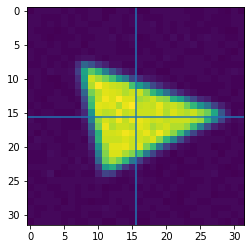

In [10]:
# determine the original image size programatically
training_dir = os.path.join(DATASET_DIR, "train")
training_imf = os.listdir(training_dir)
ORIGINAL_SHAPE = Image.open(os.path.join(training_dir, training_imf[0])).size

RESIZE_SHAPE = (32, 32) # (x, y)

# Defocusing blur
# Radius is defined in terms of the size ratio to ensure the blurring observed
# by the network is consistent even if the simulation is adjusted
GAUSS_RADIUS = 1 * RESIZE_SHAPE[0]/50 * ORIGINAL_SHAPE[0]/RESIZE_SHAPE[0]

# displace the centre randomly
CENTRE_AUGMENTATIONS = 16
CENTRE_AUGMENTATION_SIGMA = 2 * RESIZE_SHAPE[0]/50

print("\nLoading testing data...")
testing_data = DataLoader(os.path.join(DATASET_DIR, "test"), batch_size=16,
                          onload=[
                                   onload_GaussianBlur(GAUSS_RADIUS),
                                   onload_SEMNoise(),
                                   onload_MedianResizeImage(RESIZE_SHAPE),
                                 ],
                          preproc=[
                                   preproc_Normalise(),
                                   preproc_DynamicRange(1.0),
                                   preproc_Centre(),
                                   preproc_Shuffle(),
                                  ],
                          )

print(f"x_test has shape {testing_data.xdata.shape}")
print(f"y_test has shape {testing_data.ydata.shape}")
print()

im1 = testing_data.xdata[1,:,:].reshape(RESIZE_SHAPE).T
rot1 = testing_data.ydata[1]
plt.imshow(im1)
COM = ndimage.measurements.center_of_mass(im1.T)
plt.axvline(COM[0])
plt.axhline(COM[1])
print(rot1)
print(COM)
plt.show()

Loading training data...
Dataset contains 720 images
Image shape is (32, 32, 1)
Loading images...


  0%|          | 0/719 [00:00<?, ?it/s]

shuffling
x_data has shape (11520, 32, 32, 1)
y_data has shape (11520, 3, 3)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
(14.489526508811469, 17.23947848763158)


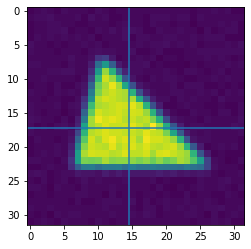


x_data values range from 0.0 to 1.0

training_data = DataLoader(dataset_dir='scalene_triangle_0_355_step5_randomdisp_5000randomtest_c0.9-1.0_b0.75-1.0/train', batch_size=16, contains 11520 images)
testing_data = DataLoader(dataset_dir='scalene_triangle_0_355_step5_randomdisp_5000randomtest_c0.9-1.0_b0.75-1.0/test', batch_size=16, contains 5000 images)


In [11]:
print("Loading training data...")
training_data = DataLoader(os.path.join(DATASET_DIR, "train"), batch_size=16,
                           onload=[
                                   onload_GaussianBlur(GAUSS_RADIUS),
                                   onload_SEMNoise(),
                                   onload_MedianResizeImage(RESIZE_SHAPE),
                                   ],
                           preproc=[
                                    preproc_Normalise(),
                                    preproc_DynamicRange(1.0),
                                    preproc_CentreAug(CENTRE_AUGMENTATION_SIGMA, CENTRE_AUGMENTATIONS),
                           ],
                           aug=[
                                #preproc_LinearAug((0.75, 1.0), (0.0, 0.0)),
                                preproc_ContrastAug(0.9, 1.0),
                                #preproc_BrightnessAug(-10/255., 0),
                                preproc_Shuffle(),
                           ]
                           )

print(f"x_data has shape {training_data.xdata.shape}")
print(f"y_data has shape {training_data.ydata.shape}")
print()

Image.open(os.path.join(DATASET_DIR, "train", sorted(os.listdir(os.path.join(DATASET_DIR, "train")))[0])).convert("L").save("original.png")
im0 = training_data.xdata[0,:,:].reshape(RESIZE_SHAPE).T
Image.fromarray((im0*255).astype("uint8"), "L").save("preprocessed.png")
rot0 = training_data.ydata[0]
plt.imshow(im0)
COM = ndimage.measurements.center_of_mass(im0.T)
plt.axvline(COM[0])
plt.axhline(COM[1])
print(rot0)
print(COM)
plt.show()

print(f"\nx_data values range from {np.min(training_data.xdata)} to {np.max(training_data.xdata)}")

print(f"\ntraining_data = {training_data}")
print(f"testing_data = {testing_data}")

Max:  0.9529412
Min:  0.0
[[-0.9396926  -0.34202015  0.        ]
 [ 0.34202015 -0.9396926   0.        ]
 [ 0.          0.          1.        ]]
(15.841033193505364, 16.485241558435085)


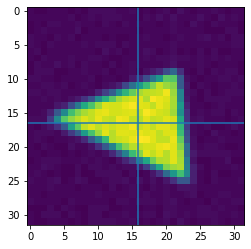

In [12]:
i = 4
im = training_data[i][0][0].reshape(RESIZE_SHAPE).T
rot = training_data[i][1][0]
plt.imshow(im)
print("Max: ", im.max())
print("Min: ", im.min())
COM = ndimage.measurements.center_of_mass(im.T)
plt.axvline(COM[0])
plt.axhline(COM[1])
print(rot)
print(COM)
plt.show()

## pim = Image.fromarray((im0).astype("uint8"), "L")
## pim_mean = onload_MeanResizeImage((32,32))(pim.copy())
## pim_median = onload_MedianResizeImage((32,32))(pim.copy())

## pim.save("original.png")
## pim.save("mean.png")
## pim.save("median.png")

## plt.imshow(np.array(pim))
## plt.show()
## plt.imshow(np.array(pim_mean))
## plt.show()
## plt.imshow(np.array(pim_median))
## plt.show()

# Construct Network

In [13]:
batch_size = training_data.batch_size
epochs = 100

model = keras.Sequential([
                          layers.InputLayer(input_shape=training_data.input_shape),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
                          layers.MaxPool2D(pool_size=2, strides=2),
                          layers.Flatten(),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(256, activation="relu"),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(np.prod(D6_SHAPE), activation="tanh"),
                          layers.Reshape(D6_SHAPE),
                          D6Convert(),
])
model.summary()
# possible new optimizer: keras.optimizers.SGD(learning_rate=0.007, momentum=0.1)
model.compile(optimizer="sgd", loss="mean_squared_error", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 64)                7

# Train Model

In [14]:
from matplotlib import gridspec
import time

VALIDATION_FRACTION = 0.1

def choose_validation(n, x, y):
  """Choose n items at random from both arrays, maintaining the same order in both.
  Items will not be duplicated."""
  x_out = np.empty((n,)+x.shape[1:], dtype=x.dtype)
  y_out = np.empty((n,)+y.shape[1:], dtype=y.dtype)

  indices = random.sample(range(n), n)
  for i, j in enumerate(indices):
    x_out[i] = x[j]
    y_out[i] = y[j]
  return x_out, y_out

x_val, y_val = choose_validation(int(testing_data.xdata.shape[0]*VALIDATION_FRACTION), testing_data.xdata, testing_data.ydata)

start_time = time.time()
history = model.fit(
    training_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    #steps_per_epoch=int(np.ceil(training_data.xdata.shape[0]/batch_size)),
    #shuffle=True,
)
end_time = time.time()
print("Training time:", end_time-start_time, "seconds")

Epoch 1/100
720/720 [==============================] - 17s 7ms/step - loss: 0.4667 - accuracy: 0.5814 - val_loss: 0.4305 - val_accuracy: 0.5967
shuffling
Epoch 2/100
720/720 [==============================] - 5s 7ms/step - loss: 0.4434 - accuracy: 0.5889 - val_loss: 0.4237 - val_accuracy: 0.6293
shuffling
Epoch 3/100
720/720 [==============================] - 5s 7ms/step - loss: 0.4167 - accuracy: 0.6111 - val_loss: 0.3313 - val_accuracy: 0.7527
shuffling
Epoch 4/100
720/720 [==============================] - 5s 7ms/step - loss: 0.1873 - accuracy: 0.7503 - val_loss: 0.0448 - val_accuracy: 0.8773
shuffling
Epoch 5/100
720/720 [==============================] - 5s 7ms/step - loss: 0.0339 - accuracy: 0.9173 - val_loss: 0.0027 - val_accuracy: 0.9760
shuffling
Epoch 6/100
720/720 [==============================] - 5s 7ms/step - loss: 0.0108 - accuracy: 0.9580 - val_loss: 0.0145 - val_accuracy: 0.9567
shuffling
Epoch 7/100
720/720 [==============================] - 5s 7ms/step - loss: 0.0067

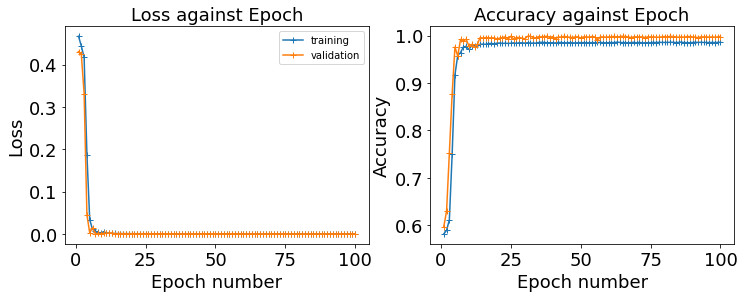

In [23]:
plt.rc('axes', labelsize=18, titlesize=18) #fontsize of the x and y labels
plt.rc('xtick', labelsize=18) #fontsize of the x tick labels
plt.rc('ytick', labelsize=18) #fontsize of the y tick labels

plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*2, plt.rcParams['figure.figsize'][1]))
gs = gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])
ax.plot([i for i in range(1, len(history.history["loss"])+1)], history.history["loss"], "+-", label="training")
ax.plot([i for i in range(1, len(history.history["val_loss"])+1)], history.history["val_loss"], "+-", label="validation")
ax.legend()
ax.set_xlabel("Epoch number")
ax.set_ylabel("Loss")
ax.set_title("Loss against Epoch")

ax = plt.subplot(gs[1])
ax.plot([i for i in range(1, len(history.history["accuracy"])+1)], history.history["accuracy"], "+-", label="training")
ax.plot([i for i in range(1, len(history.history["val_accuracy"])+1)], history.history["val_accuracy"], "+-", label="validation")
ax.set_xlabel("Epoch number")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy against Epoch")

plt.savefig("training.pdf", bbox_inches="tight")
plt.show()

# Test Model

In [16]:
score = model.evaluate(testing_data, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 7.997680950211361e-05
Test accuracy: 0.996461033821106


In [17]:
i = 6
x_test = testing_data.xdata
y_test = testing_data.ydata

print("True SO(3):\n", y_test[i].astype("float32"), end="\n\n", sep="")
prediction = model.predict(x_test[i].reshape((1,)+x_test[i].shape))[0]
print("SO(3) Prediction:\n", prediction, sep="")
print("Distance: {:.2f} degrees".format(SO3_distance(y_test[i], prediction)))

True SO(3):
[[ 0.75425136  0.65658575  0.        ]
 [-0.65658575  0.75425136  0.        ]
 [ 0.          0.          1.        ]]

SO(3) Prediction:
[[ 7.5602347e-01  6.5453923e-01 -2.6246237e-03]
 [-6.5454435e-01  7.5601572e-01 -3.4483615e-03]
 [-2.7283106e-04  4.3249754e-03  9.9999058e-01]]
Distance: 0.29 degrees


# Analyse Results

In [18]:
MULTI_RUN_MODE = True

d = np.zeros(x_test.shape[0])
predictions = model.predict(x_test)
for i in tqdm(range(x_test.shape[0])):
  d[i] = SO3_distance(y_test[i], predictions[i])

if not MULTI_RUN_MODE or "distances" not in globals():
  all_data = np.array([d])
else:
  all_data = np.append(all_data, d.reshape((1,) + d.shape), axis=0)
distances = all_data.flatten()
RUN_COUNT = all_data.shape[0]

  0%|          | 0/5000 [00:00<?, ?it/s]

## Plot Histogram

Mean distance from the true value is 0.91 +- 0.53
Median distance: 0.80
This is averaged over 5 run(s).
(run count prediction from number of distances: 5.0)
Max probability at: 0.5318020108330161


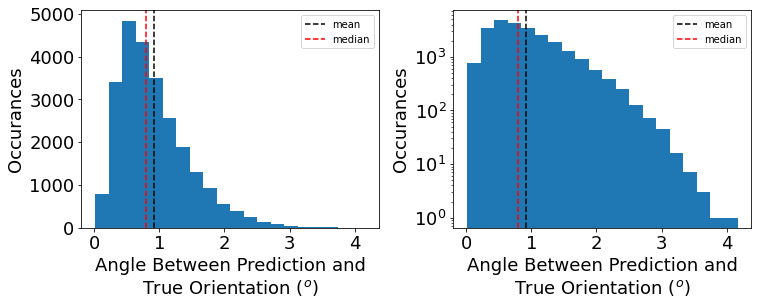

In [26]:
import scipy.stats
from scipy.optimize import curve_fit

def skewed_norm(x, mu, sigma, alpha):
  norm = scipy.stats.norm(loc=mu, scale=sigma)
  return 2*norm.pdf(x)*norm.cdf(alpha*x)

distance_mean = np.mean(distances)
distance_std = np.std(distances, ddof=1)
distance_median = np.median(distances)
print(f"Mean distance from the true value is {distance_mean:.2f} +- {distance_std:.2f}")
print(f"Median distance: {distance_median:.2f}")
print(f"This is averaged over {RUN_COUNT} run(s).")
print(f"(run count prediction from number of distances: {distances.shape[0]/x_test.shape[0]})")

plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*2, plt.rcParams['figure.figsize'][1]))
gs = gridspec.GridSpec(1, 2, wspace=0.25)

ax = plt.subplot(gs[0])
hist1 = ax.hist(distances, bins=20)
hist_x = (hist1[1][1:] + hist1[1][:-1]) / 2
ax.axvline(distance_mean, color="k", linestyle="--", label="mean")
ax.axvline(distance_median, color="r", linestyle="--", label="median")
##ax.axvline(hist_x[hist1[0].argmax()], color="r", linestyle="-")
ax.set_xlabel("Angle Between Prediction and\nTrue Orientation ($^o$)")
ax.set_ylabel("Occurances")
ax.legend()
print("Max probability at:", hist_x[hist1[0].argmax()])

# fit histogram to skewed Gaussian (actually doesn't match)
## hist_x = hist1[1][:-1]
##popt, pcov = curve_fit(skewed_norm, hist_x, hist1[0], p0=[distance_mean, distance_std, 0])
##print(popt)
##xdata = np.linspace(hist_x.min(), hist_x.max())
##ydata = skewed_norm(xdata, *popt)
##ax.plot(xdata, ydata, "-")

ax = plt.subplot(gs[1])
ax.hist(distances, bins=20, log="y")
ax.axvline(distance_mean, color="k", linestyle="--", label="mean")
ax.axvline(distance_median, color="r", linestyle="--", label="median")
ax.set_xlabel("Angle Between Prediction and\nTrue Orientation ($^o$)")
ax.set_ylabel("Occurances")
ax.legend()

plt.savefig("error_hist.pdf", bbox_inches="tight")
plt.show()

## Plot Average Error Distribution with Angle

In [27]:
angles = np.zeros((y_test.shape[0],), dtype=y_test.dtype)
for i in tqdm(range(y_test.shape[0])):
  angles[i] = np.rad2deg(R.from_matrix(y_test[i]).as_euler("zyx"))[0]
angles[angles < 0] += 360
print(angles.min(), angles.max())
# duplicate by number of runs
angles = np.stack((angles,) * RUN_COUNT, axis=0).flatten()

SPACING = 5
categories = np.linspace(0, SPACING/2, num=6)
closest_indices = np.zeros(angles.shape, dtype=np.int)
for i in tqdm(range(angles.shape[0])):
  closest_indices[i] = np.abs(categories - angles[i]%(SPACING/2)).argmin()
average_distances = np.zeros(categories.shape, dtype=distances.dtype)
for i, category in enumerate(categories):
  category_distances = distances[closest_indices == i]
  average_distances[i] = np.sum(category_distances)/category_distances.shape[0]

  0%|          | 0/5000 [00:00<?, ?it/s]

0.07 359.93


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

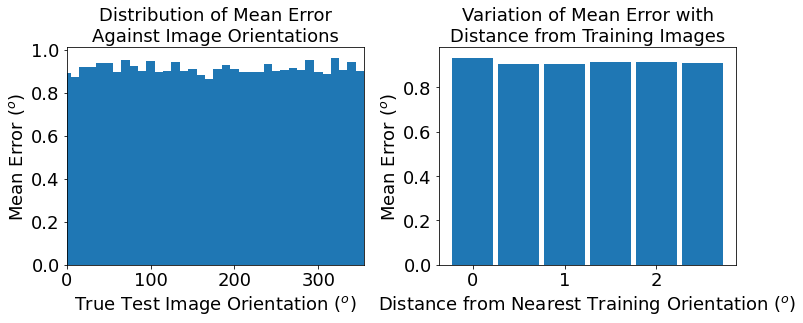

In [28]:
full_categories = np.linspace(0, 360, num=36, endpoint=False)
full_closest_indices = np.zeros(angles.shape, dtype=int)
for i in tqdm(range(angles.shape[0])):
  full_closest_indices[i] = np.abs(full_categories - angles[i]).argmin()
full_average_distances = np.zeros(full_categories.shape, dtype=distances.dtype)
for i, category in enumerate(full_categories):
  full_category_distances = distances[full_closest_indices == i]
  full_average_distances[i] = np.sum(full_category_distances)/full_category_distances.shape[0]

plt.figure(figsize=(plt.rcParams['figure.figsize'][0]*2, plt.rcParams['figure.figsize'][1]))
gs = gridspec.GridSpec(1, 2, wspace=0.25)
ax = plt.subplot(gs[0])
ax.bar(full_categories, full_average_distances, width=(360)/(full_categories.shape[0]-1))
ax.set_xlabel("True Test Image Orientation ($^o$)")
ax.set_ylabel("Mean Error ($^o$)")
ax.set_title("Distribution of Mean Error\nAgainst Image Orientations")
ax.set_xlim(0, 355)

ax = plt.subplot(gs[1])
ax.bar(categories, average_distances, width=(SPACING/2)/(categories.shape[0]-1)-0.05)
ax.set_xlabel("Distance from Nearest Training Orientation ($^o$)")
ax.set_ylabel("Mean Error ($^o$)")
ax.set_title("Variation of Mean Error with\nDistance from Training Images")

plt.savefig("angular_error_hist.pdf", bbox_inches="tight")
plt.show()

In [ ]:
#np.savetxt("distances.csv", distances, delimiter=",")
DATA_FILENAME = "all_data_2D_final"
DATA_SAVE_PATH = os.path.join(drive_dir, "MyDrive", "ml_data", DATA_FILENAME)

# make filename unique to avoid overwriting
count = 1
while os.path.exists(DATA_SAVE_PATH):
  fn, ext = os.path.splitext(DATA_FILENAME)
  fn += " ({})".format(count)
  count += 1
  DATA_SAVE_PATH = os.path.join(drive_dir, "MyDrive", "ml_data", fn+ext)

np.savetxt("all_data.csv", all_data, delimiter=",")
np.savetxt(DATA_SAVE_PATH, all_data, delimiter=",")

-------------

# Licenses

Parts of this project are modifications of works created as part of tensorflow. tensorflow is subject to the Apache 2.0 license. In compliance with this license, the Apache 2.0 license and tensorflow's official list of authors are replicated below. At the time of writing, tensorflow's source distribution does not include any `NOTICE` files. 

Any modifications of works created as part of tensorflow are marked as such in accordance with the Apache 2.0 license.

## Tensorflow Authors

```
Google Inc.
Yuan Tang <terrytangyuan@gmail.com>
```

## Apache 2.0 License

The Apache 2.0 License is included below.

```
                                 Apache License
                           Version 2.0, January 2004
                        http://www.apache.org/licenses/

   TERMS AND CONDITIONS FOR USE, REPRODUCTION, AND DISTRIBUTION

   1. Definitions.

      "License" shall mean the terms and conditions for use, reproduction,
      and distribution as defined by Sections 1 through 9 of this document.

      "Licensor" shall mean the copyright owner or entity authorized by
      the copyright owner that is granting the License.

      "Legal Entity" shall mean the union of the acting entity and all
      other entities that control, are controlled by, or are under common
      control with that entity. For the purposes of this definition,
      "control" means (i) the power, direct or indirect, to cause the
      direction or management of such entity, whether by contract or
      otherwise, or (ii) ownership of fifty percent (50%) or more of the
      outstanding shares, or (iii) beneficial ownership of such entity.

      "You" (or "Your") shall mean an individual or Legal Entity
      exercising permissions granted by this License.

      "Source" form shall mean the preferred form for making modifications,
      including but not limited to software source code, documentation
      source, and configuration files.

      "Object" form shall mean any form resulting from mechanical
      transformation or translation of a Source form, including but
      not limited to compiled object code, generated documentation,
      and conversions to other media types.

      "Work" shall mean the work of authorship, whether in Source or
      Object form, made available under the License, as indicated by a
      copyright notice that is included in or attached to the work
      (an example is provided in the Appendix below).

      "Derivative Works" shall mean any work, whether in Source or Object
      form, that is based on (or derived from) the Work and for which the
      editorial revisions, annotations, elaborations, or other modifications
      represent, as a whole, an original work of authorship. For the purposes
      of this License, Derivative Works shall not include works that remain
      separable from, or merely link (or bind by name) to the interfaces of,
      the Work and Derivative Works thereof.

      "Contribution" shall mean any work of authorship, including
      the original version of the Work and any modifications or additions
      to that Work or Derivative Works thereof, that is intentionally
      submitted to Licensor for inclusion in the Work by the copyright owner
      or by an individual or Legal Entity authorized to submit on behalf of
      the copyright owner. For the purposes of this definition, "submitted"
      means any form of electronic, verbal, or written communication sent
      to the Licensor or its representatives, including but not limited to
      communication on electronic mailing lists, source code control systems,
      and issue tracking systems that are managed by, or on behalf of, the
      Licensor for the purpose of discussing and improving the Work, but
      excluding communication that is conspicuously marked or otherwise
      designated in writing by the copyright owner as "Not a Contribution."

      "Contributor" shall mean Licensor and any individual or Legal Entity
      on behalf of whom a Contribution has been received by Licensor and
      subsequently incorporated within the Work.

   2. Grant of Copyright License. Subject to the terms and conditions of
      this License, each Contributor hereby grants to You a perpetual,
      worldwide, non-exclusive, no-charge, royalty-free, irrevocable
      copyright license to reproduce, prepare Derivative Works of,
      publicly display, publicly perform, sublicense, and distribute the
      Work and such Derivative Works in Source or Object form.

   3. Grant of Patent License. Subject to the terms and conditions of
      this License, each Contributor hereby grants to You a perpetual,
      worldwide, non-exclusive, no-charge, royalty-free, irrevocable
      (except as stated in this section) patent license to make, have made,
      use, offer to sell, sell, import, and otherwise transfer the Work,
      where such license applies only to those patent claims licensable
      by such Contributor that are necessarily infringed by their
      Contribution(s) alone or by combination of their Contribution(s)
      with the Work to which such Contribution(s) was submitted. If You
      institute patent litigation against any entity (including a
      cross-claim or counterclaim in a lawsuit) alleging that the Work
      or a Contribution incorporated within the Work constitutes direct
      or contributory patent infringement, then any patent licenses
      granted to You under this License for that Work shall terminate
      as of the date such litigation is filed.

   4. Redistribution. You may reproduce and distribute copies of the
      Work or Derivative Works thereof in any medium, with or without
      modifications, and in Source or Object form, provided that You
      meet the following conditions:

      (a) You must give any other recipients of the Work or
          Derivative Works a copy of this License; and

      (b) You must cause any modified files to carry prominent notices
          stating that You changed the files; and

      (c) You must retain, in the Source form of any Derivative Works
          that You distribute, all copyright, patent, trademark, and
          attribution notices from the Source form of the Work,
          excluding those notices that do not pertain to any part of
          the Derivative Works; and

      (d) If the Work includes a "NOTICE" text file as part of its
          distribution, then any Derivative Works that You distribute must
          include a readable copy of the attribution notices contained
          within such NOTICE file, excluding those notices that do not
          pertain to any part of the Derivative Works, in at least one
          of the following places: within a NOTICE text file distributed
          as part of the Derivative Works; within the Source form or
          documentation, if provided along with the Derivative Works; or,
          within a display generated by the Derivative Works, if and
          wherever such third-party notices normally appear. The contents
          of the NOTICE file are for informational purposes only and
          do not modify the License. You may add Your own attribution
          notices within Derivative Works that You distribute, alongside
          or as an addendum to the NOTICE text from the Work, provided
          that such additional attribution notices cannot be construed
          as modifying the License.

      You may add Your own copyright statement to Your modifications and
      may provide additional or different license terms and conditions
      for use, reproduction, or distribution of Your modifications, or
      for any such Derivative Works as a whole, provided Your use,
      reproduction, and distribution of the Work otherwise complies with
      the conditions stated in this License.

   5. Submission of Contributions. Unless You explicitly state otherwise,
      any Contribution intentionally submitted for inclusion in the Work
      by You to the Licensor shall be under the terms and conditions of
      this License, without any additional terms or conditions.
      Notwithstanding the above, nothing herein shall supersede or modify
      the terms of any separate license agreement you may have executed
      with Licensor regarding such Contributions.

   6. Trademarks. This License does not grant permission to use the trade
      names, trademarks, service marks, or product names of the Licensor,
      except as required for reasonable and customary use in describing the
      origin of the Work and reproducing the content of the NOTICE file.

   7. Disclaimer of Warranty. Unless required by applicable law or
      agreed to in writing, Licensor provides the Work (and each
      Contributor provides its Contributions) on an "AS IS" BASIS,
      WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
      implied, including, without limitation, any warranties or conditions
      of TITLE, NON-INFRINGEMENT, MERCHANTABILITY, or FITNESS FOR A
      PARTICULAR PURPOSE. You are solely responsible for determining the
      appropriateness of using or redistributing the Work and assume any
      risks associated with Your exercise of permissions under this License.

   8. Limitation of Liability. In no event and under no legal theory,
      whether in tort (including negligence), contract, or otherwise,
      unless required by applicable law (such as deliberate and grossly
      negligent acts) or agreed to in writing, shall any Contributor be
      liable to You for damages, including any direct, indirect, special,
      incidental, or consequential damages of any character arising as a
      result of this License or out of the use or inability to use the
      Work (including but not limited to damages for loss of goodwill,
      work stoppage, computer failure or malfunction, or any and all
      other commercial damages or losses), even if such Contributor
      has been advised of the possibility of such damages.

   9. Accepting Warranty or Additional Liability. While redistributing
      the Work or Derivative Works thereof, You may choose to offer,
      and charge a fee for, acceptance of support, warranty, indemnity,
      or other liability obligations and/or rights consistent with this
      License. However, in accepting such obligations, You may act only
      on Your own behalf and on Your sole responsibility, not on behalf
      of any other Contributor, and only if You agree to indemnify,
      defend, and hold each Contributor harmless for any liability
      incurred by, or claims asserted against, such Contributor by reason
      of your accepting any such warranty or additional liability.

   END OF TERMS AND CONDITIONS

   APPENDIX: How to apply the Apache License to your work.

      To apply the Apache License to your work, attach the following
      boilerplate notice, with the fields enclosed by brackets "[]"
      replaced with your own identifying information. (Don't include
      the brackets!)  The text should be enclosed in the appropriate
      comment syntax for the file format. We also recommend that a
      file or class name and description of purpose be included on the
      same "printed page" as the copyright notice for easier
      identification within third-party archives.

   Copyright [yyyy] [name of copyright owner]

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

## Some of TensorFlow's code is derived from Caffe, which is subject to the following copyright notice:

COPYRIGHT

All contributions by the University of California:

Copyright (c) 2014, The Regents of the University of California (Regents)
All rights reserved.

All other contributions:

Copyright (c) 2014, the respective contributors
All rights reserved.

Caffe uses a shared copyright model: each contributor holds copyright over
their contributions to Caffe. The project versioning records all such
contribution and copyright details. If a contributor wants to further mark
their specific copyright on a particular contribution, they should indicate
their copyright solely in the commit message of the change when it is
committed.

LICENSE

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

   THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
   ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
   WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
   DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR
   ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
   (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
   LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND
   ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
   (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
   SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

CONTRIBUTION AGREEMENT

By contributing to the BVLC/caffe repository through pull-request, comment,
or otherwise, the contributor releases their content to the
license and copyright terms herein.
```